## *Historical and Sociocultural Analysis of the Impact of World Events on Film Genre Trends*

 This project will explore historical trends in film genres, analyzing how societal and historical events—such as wars, economic shifts, and cultural influences—affect the popularity of genres. 
 The goal is to understand how historical events and cultural dynamics shape film genre trends over time and understand how periods of conflict, economic upheaval, or stability shape audience preferences and genre popularity.

In [92]:
import matplotlib.pyplot as plt 


import pandas as pd
import numpy as np
import seaborn as sns
from src.utils.appendix import *
from sklearn.preprocessing import MultiLabelBinarizer 
from sklearn.linear_model import LinearRegression

import geopandas as gpd
import plotly.graph_objects as go
from IPython.display import Image
from statsmodels.formula.api import ols
import pingouin as pg
from scipy.stats import kruskal
from scipy.stats import shapiro
%load_ext autoreload
%autoreload 2
from src.utils.data_cleaning2 import *
from src.utils.visualization import *
from src.utils.appendix import *
import statsmodels.api as sms
import statsmodels.api as sm
from sklearn.metrics import r2_score


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Movies Dataset

For this part of the notebook, we will use the provided movie dataset, which has been cleaned and preprocessed specifically for our project. We will focus on key columns that are particularly relevant to our analysis, notably the genres of the movies and the countries involved in their production.

METTRE LES CELLS EXPLIQUANT LE PREPROCESSING

In [26]:
raw_movies_data = pd.read_csv("data/MoviesDataset/movie.metadata.zip", header= None, delimiter='\t')
clean_movies_data = preprocess_movies(raw_movies_data)
processed_data_path = 'data/Preprocessed_data/preprocessed_movie_metadata.csv'
clean_movies_data.to_csv(processed_data_path, encoding='utf-8', errors='ignore', index=False)

In [27]:
preprocessed_movies = pd.read_csv(processed_data_path)
preprocessed_movies.head(2)

,Movie name,Movie box office revenue,Movie runtime,Languages,Countries,Genres,Year
0,Ghosts of Mars,14010832.0,98.0,English,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001
1,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,English,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000


## Historical Events Dataset

Initially, we integrated the <u>*World Important Events: Ancient to Modern*</u> dataset to explore correlations between historical events and film genre trends. While it provided comprehensive coverage of events, its scope and complexity posed challenges for analysis and interpretation in our specific context. However, we will sometimes use it as a complement, which is why we preprocess it as follows:

In [28]:
raw_history_data= pd.read_csv("data/HistoricalDataset/historical.dataset.zip")
first_movie_year = preprocessed_movies['Year'].min()
last_movie_year = preprocessed_movies['Year'].max()
cleaned_events = preprocess_events(raw_history_data, first_movie_year, last_movie_year)
events_countries = cleaned_events['Country'].unique()
movies_countries = preprocessed_movies['Countries'].str.split(', ').explode().unique()
#Elements in events_countries that are not in movies_countries
not_in_movies_dataset = [item for item in events_countries if item not in movies_countries]
cleaned_events = cleaned_events[cleaned_events['Country'].isin(movies_countries)]
processed_data_path = 'data/Preprocessed_data/preprocessed_movie_metadata.csv'
clean_movies_data.to_csv(processed_data_path, encoding='utf-8', errors='ignore', index=False)
preprocessed_history = cleaned_events.copy()

To remedy this, we created a new dataset manually, with the help of a linguistic model (LM) and our own ideas that we felt were relevant. 

Since it is a small, hand-crafted dataset, no preprocessing is required. Here are a few lines:

In [29]:
historical_events_df = pd.read_csv("data/manual_historical_dataset.csv")
historical_events_df.head()

,Event Name,Year,Location,Impact Type,Description
0,World War II,1939,Global,Negative,Major conflict influencing war movies and hist...
1,Great Depression,1929,USA,Negative,Economic collapse led to the rise of escapist ...
2,Civil Rights Movement,1954,USA,Mixed,Influenced films addressing racial issues and ...
3,Cold War,1947,Global,Mixed,Tension between superpowers popularized spy an...
4,Vietnam War,1955,USA,Negative,Affected war films and anti-war dramas in the ...


## RAJOUTER EDA ??

Before diving into specific case studies, such as examining the popular film genres around the time of World War II, we will take a broader approach. First, we will analyze the most represented genres by decade and by country. Additionally, we will conduct an initial exploration to see if there are any apparent correlations between these trends and the historical events in our dataset.

First, we take the most popular movie genres based on sources (https://www.statista.com/statistics/188658/movie-genres-in-north-america-by-box-office-revenue-since-1995/ & https://www.the-numbers.com/market/genres).

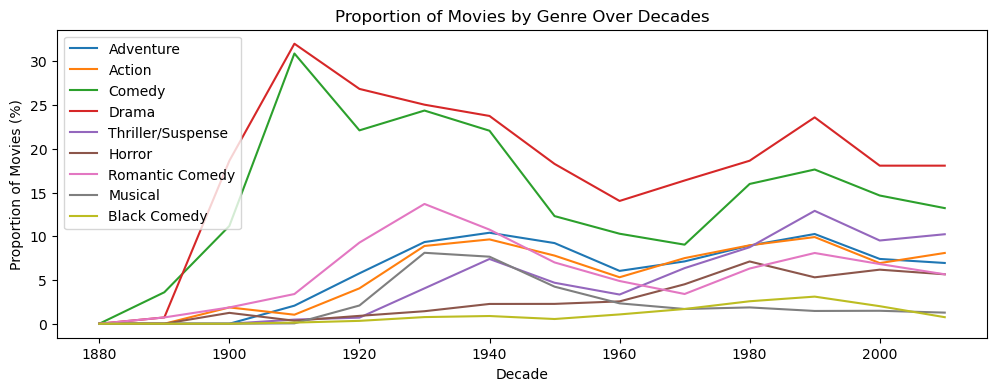

In [30]:
# Lets select some of the genres :
genres = [
    "Adventure",
    "Action",
    "Comedy",
    "Drama",
    "Thriller/Suspense",
    "Horror",
    "Romantic Comedy",
    "Musical",
    "Black Comedy"
]

# Filter the preprocessed movies to only include the selected genres
filtered_movies = preprocessed_movies[preprocessed_movies['Genres'].str.contains('|'.join(genres), case=False, na=False)]
genre_counts = filtered_movies['Genres'].str.split(', ').explode().value_counts()
filtered_genre_counts = genre_counts[genre_counts.index.isin(genres)]

related_genres = {
    "Adventure": ["Adventure", "Adventure Comedy", "Action/Adventure"],
    "Action": ["Action", "Action/Adventure", "Action Comedy", "Action Thrillers"],
    "Comedy": ["Comedy", "Comedy-drama", "Adventure Comedy", "Black comedy", "Romantic comedy", 
               "Comedy horror", "Musical comedy", "Screwball comedy", "Comedy Western", "Comedy Thriller"],
    "Drama": ["Drama", "Comedy-drama", "Romantic drama", "Political drama", "Historical drama", 
              "Family Drama", "Melodrama"],
    "Thriller/Suspense": ["Thriller", "Suspense", "Crime Thriller", "Psychological thriller", 
                          "Erotic thriller", "Political thriller"],
    "Horror": ["Horror", "Natural horror films", "Horror Comedy", "Psychological horror", "Slasher"],
    "Romantic Comedy": ["Romantic comedy", "Romantic drama", "Romance Film"],
    "Musical": ["Musical", "Musical comedy", "Musical Drama", "Animated Musical"],
    "Black Comedy": ["Black comedy", "Dark comedy", "Satire", "Comedy Thriller"]
}

# Calculate total movies per decade
total_movies_per_decade = group_by_decade(preprocessed_movies.copy())

plot_movie_genres_per_decade(related_genres,total_movies_per_decade,preprocessed_movies)

We are seeing a number of things: 
- The rise of the “Musical” in the 1930s-1950s: This peak may coincide with the rise of Hollywood musicals after the Great Depression and during the Second World War, a period when entertainment was important.
- The gradual decline of “Dramas” after 1940: This may be linked to a shift in public demand towards lighter or more spectacular genres (such as action and adventure).
- The rise of “Thrillers/Suspense” and “Horror” after 1960-1980: May coincide with periods of social or political tension (Cold War, oil crisis).
-The rise of Action films from the 1980s: This could be linked to technological advances in special effects and the rise of iconic heroes.

Now, let’s take a first look at the potential correlations between our historical events dataset and the distribution of the most prominent movie genres over time:

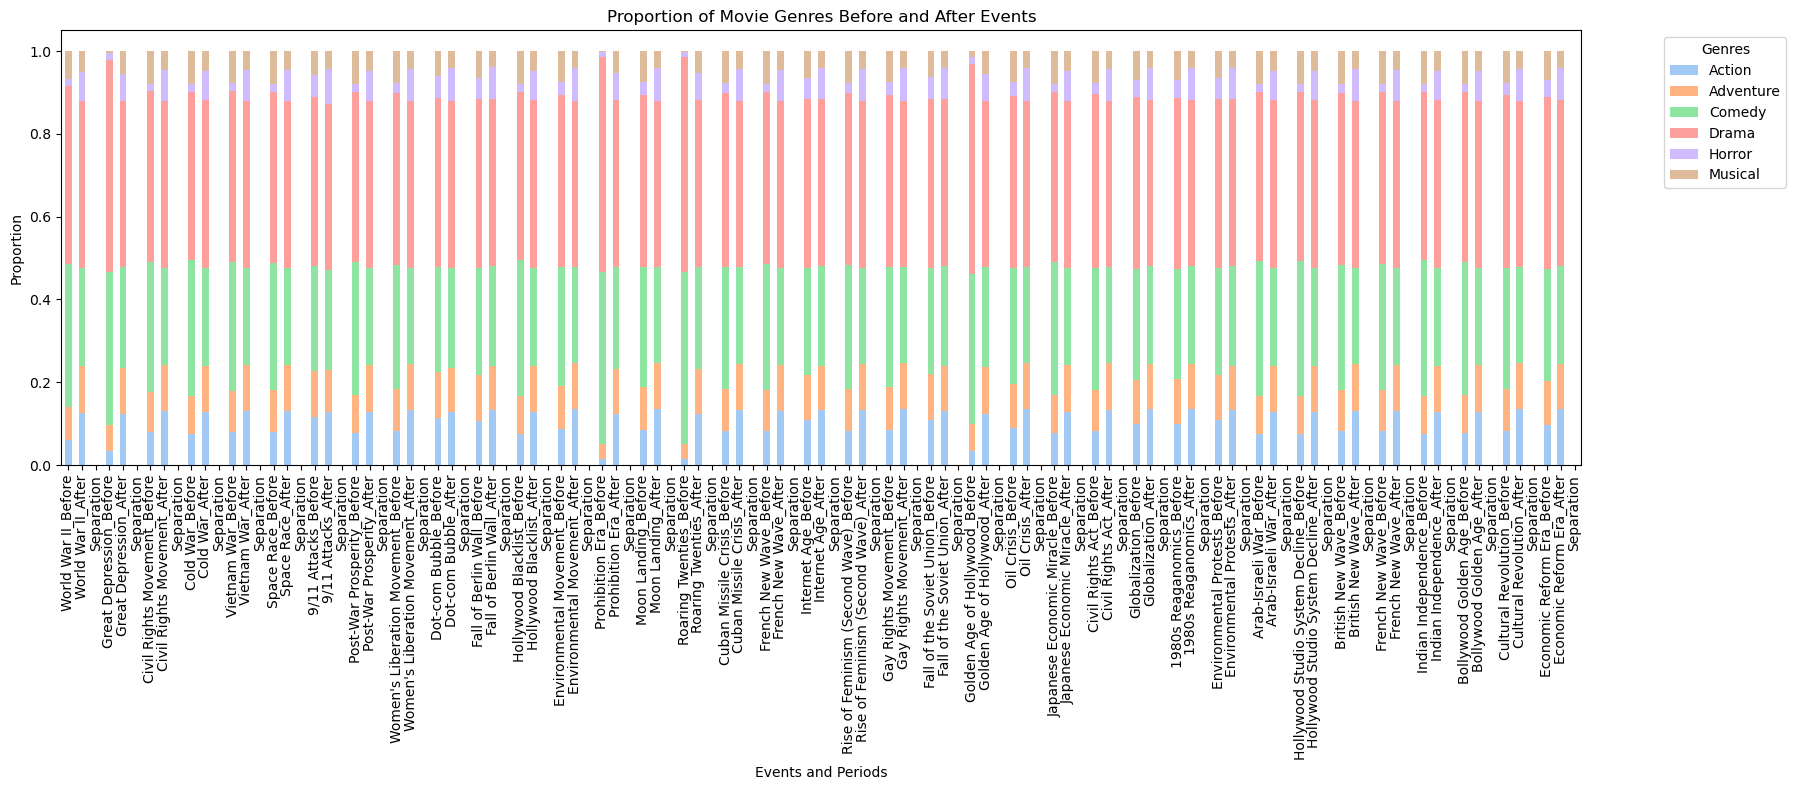

In [31]:
#Global plot to motivate our question
historical = historical_events_df.copy()
movies = preprocessed_movies.copy()

genres_of_interest = [ "Adventure", "Action", "Comedy", "Drama", "Thriller/Suspense",
                        "Horror", "Romantic Comedy", "Musical", "Black Comedy"]

movies['Filtered_Genres'] = movies['Genres'].apply(
    lambda x: genre_filter(x, genres_of_interest)
)
movies = movies.explode('Filtered_Genres').dropna(
    subset=['Filtered_Genres']
)

plot_global_plot(historical,movies)

The stacked bar plot above provides an overview of the changes in movie genre proportions before and after significant historical events. For each event, the "Before" and "After" distributions are allowing us to observe any shifts in the prominence of certain genres.

From this plot, we can observe that:

-Comedy and Drama consistently dominate the overall genre distribution, regardless of the event period.

-The proportions of action-related genres (Action and Adventure) tend to increase after certain events, possibly reflecting a cultural or societal shift toward escapism or hero-centric narratives.

-Other genres, such as Musical and Horror, remain minor yet show specific spikes after certain events, suggesting a contextual influence.

For greater clarity, we have segmented our dataset by the most represented countries and plotted important global and specific country events:

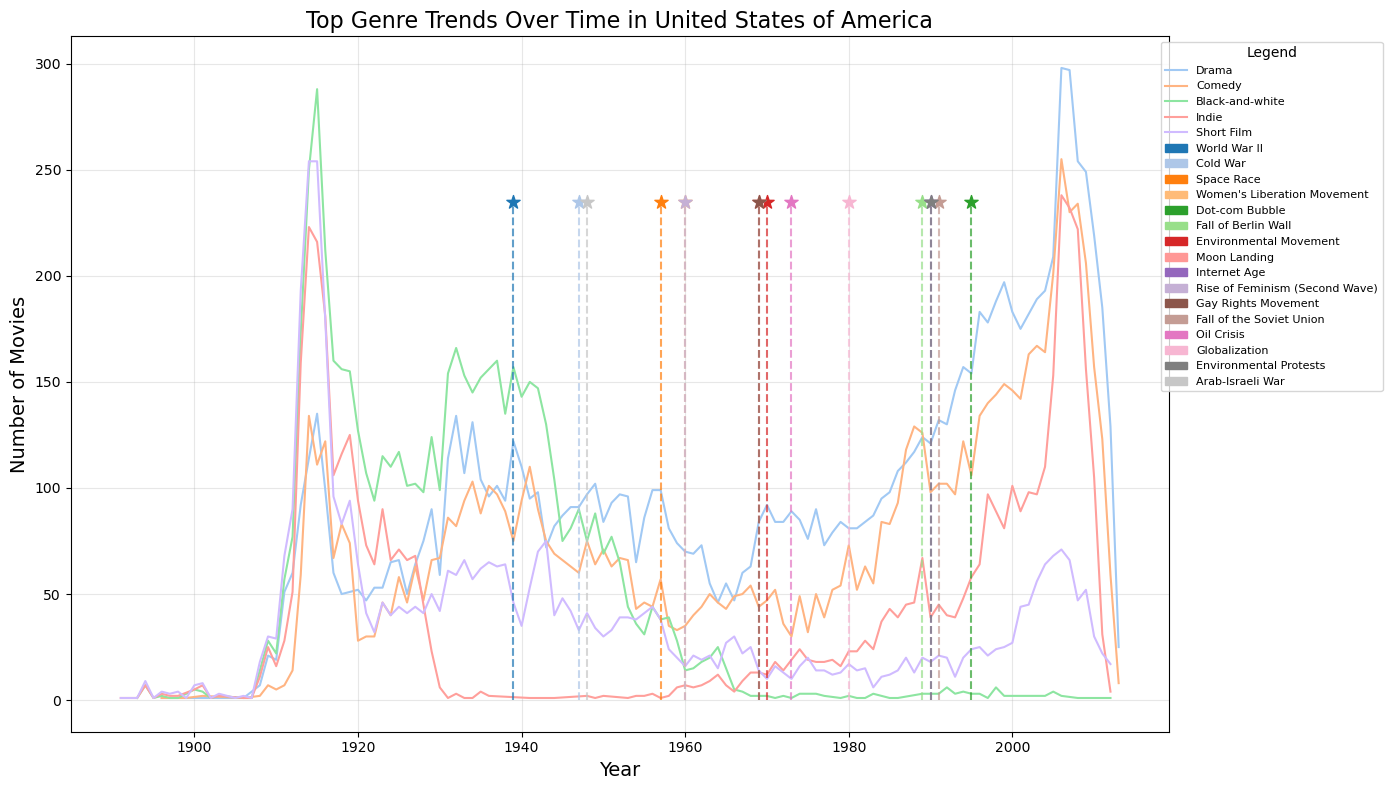

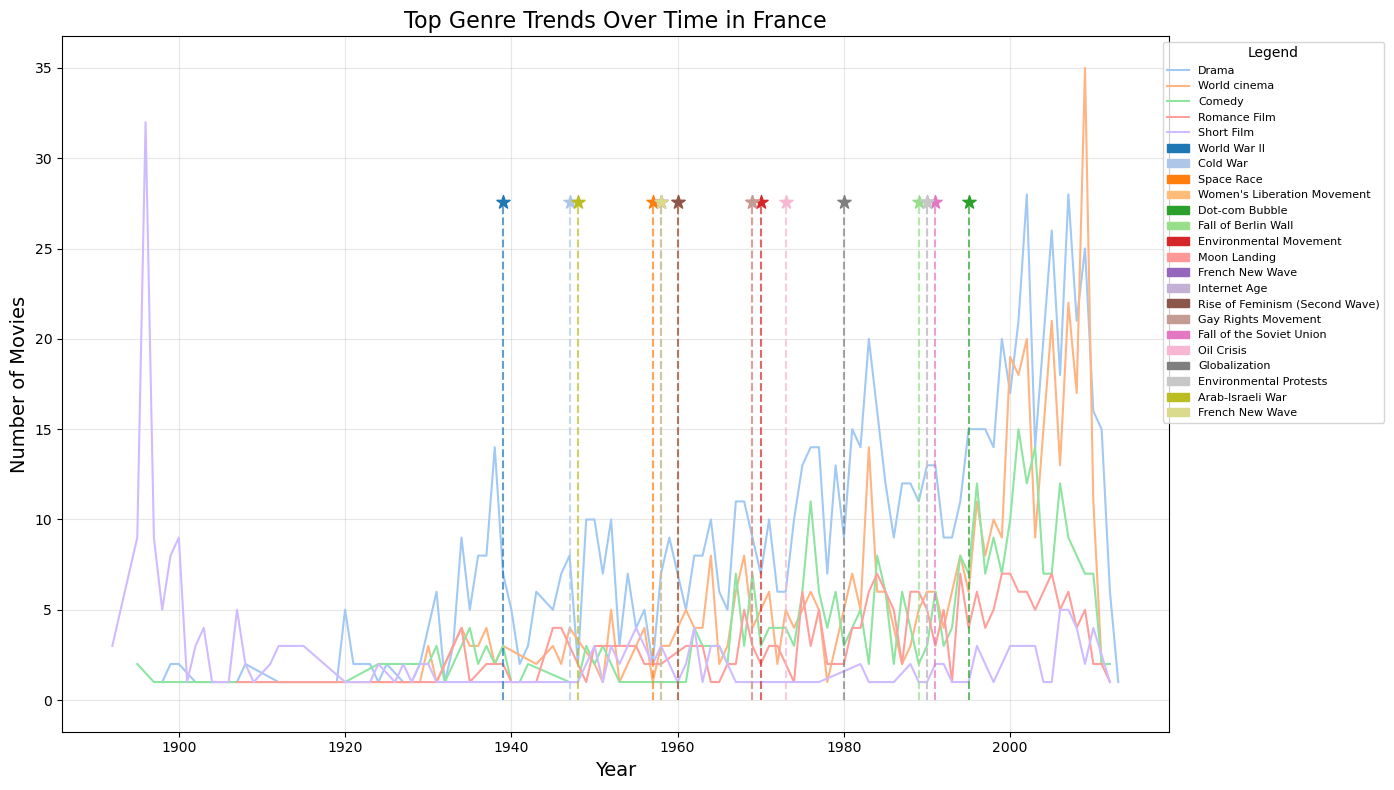

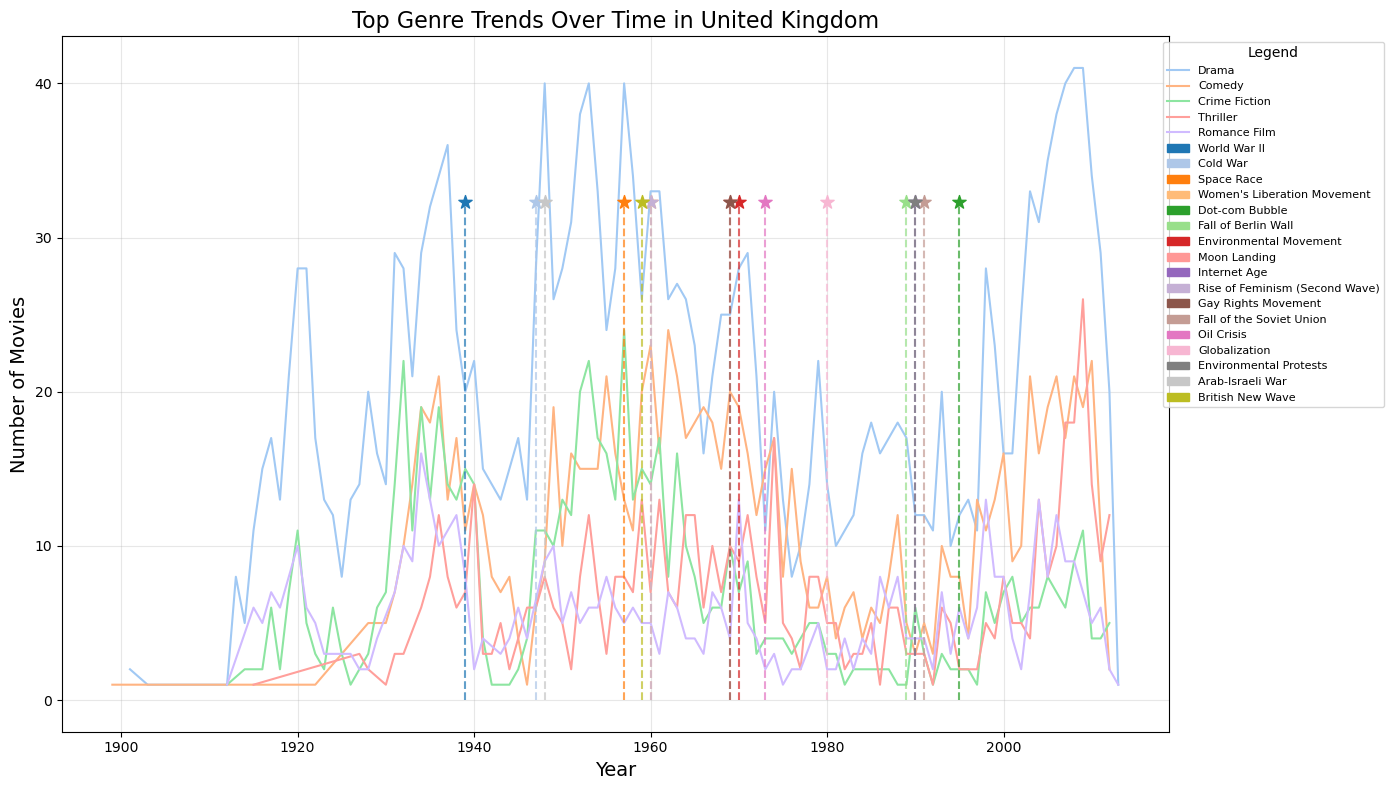

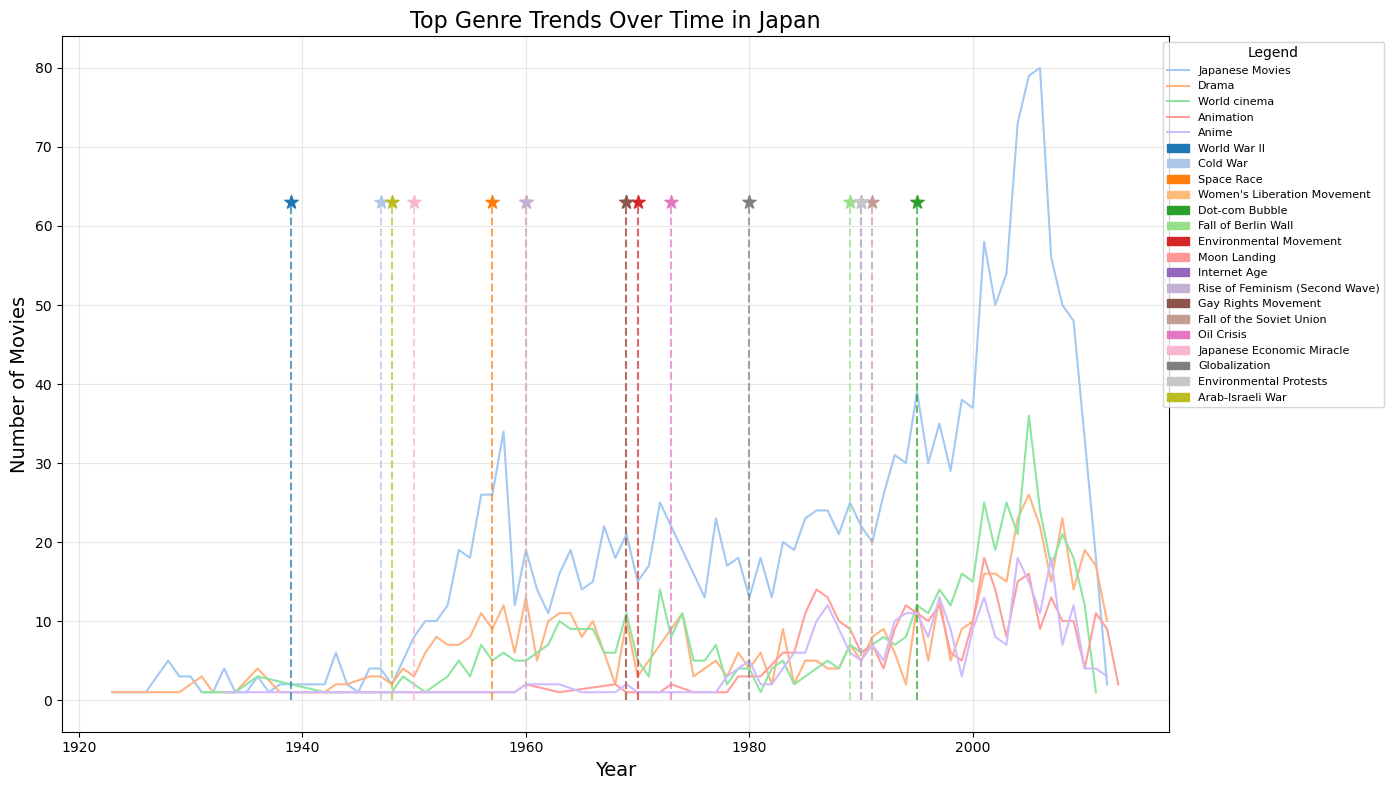

In [32]:
movie_metadata = preprocessed_movies.copy()
historical_data = historical_events_df.copy()

movie_metadata['Genres'] = movie_metadata['Genres'].str.split(', ')
genres_over_time = movie_metadata.explode('Genres').groupby(['Year', 'Genres']).size().reset_index(name='Count')

#Display of most represented countries and top genres
countries = ["United States of America", "France", "United Kingdom", "Japan"]

for country in countries:
    plot_genre_trends_per_country(country,historical_data,movie_metadata)

We cannot see the details clearly from these plots, so let’s focus on one of the most significant and impactful cases: World War II. We will now take a closer look at the trends surrounding war movies during this period.

## **Inflence of history over film industry: Immediate or long-lasting effect ?**

In this analysis, we explore how major historical events and broader social movements influence the film industry. Our goal is to determine whether such events lead to immediate, short-term spikes in the production of specific types of films or whether they contribute to long-term, sustained trends over time. By identifying these patterns, we aim to better understand the relationship between significant moments in history and their lasting impact on cinema.

To illustrate this, we will examine two major examples:

1) **War Movies**: Using World War II as a case study, we analyze how these historical event influenced the production of war films.

2) **LGBT Movies**: In contrast, we study how the representation of LGBT themes in cinema has evolved over time, particularly in relation to key social movements such as the first LGBT pride marches.

We will test wether these movements led to gradual, sustained increases orn short-term spikes in related-topic movie production


### ➔ War Movies and WWII

Total number of War movies: 2467
Total number of War-Comedy movies: 225
Total number of War-Drama movies: 1656


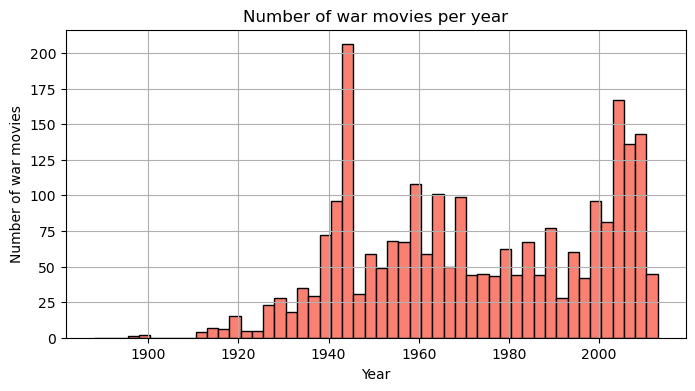

In [90]:
War_movies = preprocessed_movies[preprocessed_movies['Genres'].str.contains(r'war', case=False, na=False)]
War_movies_comedy = War_movies[War_movies['Genres'].str.contains(r'comedy', case=False, na=False)]
War_movies_drama = War_movies[War_movies['Genres'].str.contains(r'drama', case=False, na=False)]

print(f"Total number of War movies: {len(War_movies)}")
print(f"Total number of War-Comedy movies: {len(War_movies_comedy)}")
print(f"Total number of War-Drama movies: {len(War_movies_drama)}")

plt.figure(figsize=(8,4))
War_movies["Year"].hist(bins=50, range=(preprocessed_movies["Year"].min(), preprocessed_movies["Year"].max()), color = 'salmon', edgecolor = 'black')
plt.xlabel("Year")
plt.ylabel("Number of war movies")
plt.title("Number of war movies per year")
plt.show()


The plot shows the number of war movies produced each year. There is a significant increase in war movie production during the 1940s, which aligns with World War II, suggesting that the conflict likely influenced the film industry. Another peak appears around the early 2000s.

We know that the distribution of the movies is skewed to the right, so let's focus on the proportion rather than the number of movies.

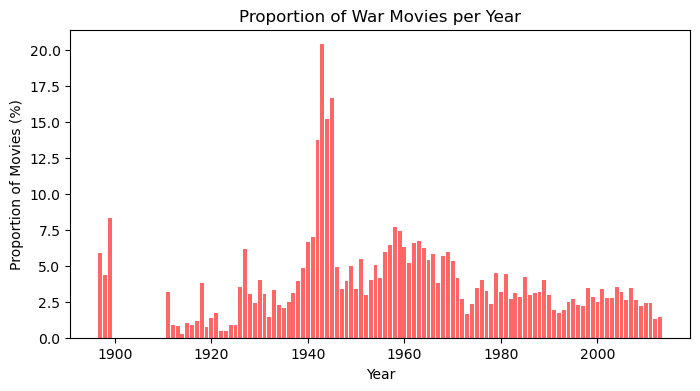

In [91]:
total_movies_per_year = preprocessed_movies.groupby('Year').size()
war_movies_per_year = War_movies.groupby('Year').size()

#proportion of each category of movie per year
war_movies_proportion = (war_movies_per_year / total_movies_per_year)*100
plot_bar(war_movies_proportion.index, war_movies_proportion.values, 'Year', 'Proportion of Movies (%)', 'Proportion of War Movies per Year')

The graph suggests a strong association of war movie production with the World War II era, where the genre’s prominence reached a historical high. We notice a sharp and tempory increase of war movie production. 
We will test if this peak is netherless statisticall significatif.

### **Hypothesis testing** : First we will test if there is a significant difference in war movie production before during and after the WWWI.

Null Hypothesis (H0): The proportion of war-themed movies is not significantly different before, during, and after World War II. In other words, WWII had no measurable effect on the trend in war movie production.

Alternative Hypothesis (H1): The proportion of war-themed movies increased significantly as a result of World War II or in the years immediately following it.

In [35]:
periods = {
    "before_WWII": (1930, 1939),
    #As WWI start in september 1939 we will consider the start at 1940
    "during_WWII": (1940, 1945),
    "after_WWII": (1946, 1970)
}

# Calculate proportions of war movies for each period
proportions = {
    name: (War_movies[War_movies['Year'].between(start, end)]
           .groupby('Year').size() / total_movies_per_year.loc[start:end]) * 100
    for name, (start, end) in periods.items()
}

for name, prop in proportions.items():
    print(f"Proportion of war movies {name.replace('_', ' ')}: {prop.mean():.2f}%")

Proportion of war movies before WWII: 3.06%
Proportion of war movies during WWII: 13.26%
Proportion of war movies after WWII: 5.31%


--> we need to test for normality of the data. Based on the result we could decide to run a parametric or non parametric statistica test

In [36]:
#Check normality of the before/during/after WWII movies

print('Null Hyopthesis H0: The data are not normally distributed \n')
for name, prop in proportions.items():
    stat, p = shapiro(prop.values)
    print(f"{name.replace('_', ' ').capitalize()} p-value: {p:.4f}")

Null Hyopthesis H0: The data are not normally distributed 

Before wwii p-value: 0.9729
During wwii p-value: 0.4533
After wwii p-value: 0.7265


All the p_values are above 0.05. The data do not significantly deviate from a normal distribution. The test does not provide evidence that the data are non-normal so we will use a parametric test. We will use an ANOVA (Analysis of Variance) test  to determine whether there are statistically significant differences between the means of three or more independent groups. It compares the variance within groups to the variance between groups to identify if at least one group mean is significantly different. Then if ANOVA is osignificant , the Tukey post-hoc test is used to identify which specific pairs of group means are significantly different from each other. 

In [125]:
all_values = pd.concat([
    pd.DataFrame({'Proportion': prop.values, 'Group': name.split('_')[0].capitalize()})
    for name, prop in proportions.items()
])

# One-Way ANOVA
anova_table = sm.stats.anova_lm(ols('Proportion ~ Group', data=all_values).fit(), typ=2)
print(anova_table)

# Check ANOVA significance and perform Tukey post-hoc test
if anova_table['PR(>F)'].iloc[0] < 0.05:
    print("There is a significant difference between at least one pair of groups.")
    print(pg.pairwise_tukey(data=all_values, dv='Proportion', between='Group'))
else:
    print("There is no significant difference between the proportions of war movies.")

              sum_sq    df          F        PR(>F)
Group     414.329234   2.0  40.041899  4.408312e-10
Residual  196.600451  38.0        NaN           NaN
There is a significant difference between at least one pair of groups.
        A       B   mean(A)    mean(B)       diff        se         T  \
0   After  Before  5.312585   3.061248   2.251337  0.851068  2.645307   
1   After  During  5.312585  13.261465  -7.948880  1.034036 -7.687237   
2  Before  During  3.061248  13.261465 -10.200217  1.174586 -8.684095   

        p-tukey    hedges  
0  3.098727e-02  1.831940  
1  8.783722e-09 -3.045361  
2  4.412432e-10 -2.868717  


The ANOVA results indicate a significant difference between at least one pair of groups (F = 40.04, p < 0.001), suggesting that the proportions of war movies across the three periods (Before, During, and After WWII) are not equal.

The Tukey post-hoc test reveals the following:

After vs. Before: The difference is significant (p = 0.031), with a mean difference of 2.25, suggesting slightly higher proportions after WWII.
After vs. During: The difference is highly significant (p < 0.001), with a large negative mean difference (-7.95), showing proportions were much higher during WWII compared to after.
Before vs. During: The difference is also highly significant (p < 0.001), with a mean difference of -10.20, indicating a dramatic increase in proportions during WWII compared to before.

### -> **Model Fitting** Now we will see if we could well explain the trends using year and/ dummy variables to reprensent the 3 categories only: Before, during after WWI

We will fit a model with different prediction : year and the dummy variables and see which model perform the best using R_squared value.

In [94]:
# Convert series to a DataFrame
war_movies = war_movies_proportion.to_frame(name='Proportion').reset_index()
war_movies = war_movies[war_movies['Year'] > 1925]

#Create all the dummies variable 
war_movies['Before_WWII'] = (war_movies['Year'] < 1940).astype(int)
# Choose 1941 for the start of WWI because it better fit to the peak of the war movies. An 1 year for movie production doesn't seem too much to consider.
war_movies['During_WWII'] = ((war_movies['Year'] >= 1941) & (war_movies['Year'] <= 1945)).astype(int)
war_movies['After_WWII'] = (war_movies['Year'] >= 1946).astype(int)

*1st Case: The predictors choose are : YEAR- DURING - AFTER*

R-squared: 0.7417


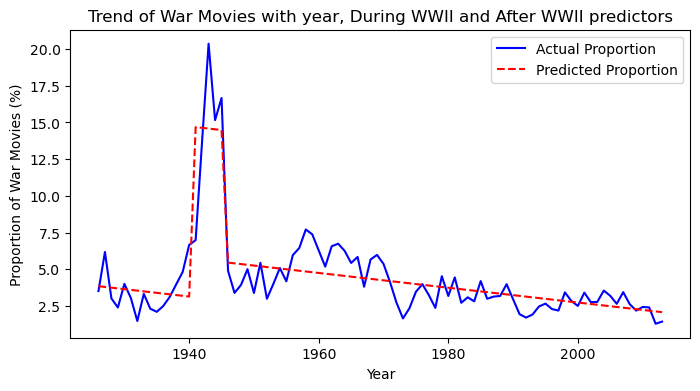

In [103]:
# Prepare the data
X = war_movies[['Year', 'During_WWII', 'After_WWII']]
y = war_movies['Proportion'].values

model, predicted_proportions1, summary1 = fit_and_evaluate_model(X, y)

r2 = r2_score(y, predicted_proportions1)
print(f"R-squared: {r2:.4f}")

plot_actual_vs_predicted(
    years=war_movies['Year'],
    actual=y,
    predicted=predicted_proportions1,
    model=model,
    title='Trend of War Movies with year, During WWII and After WWII predictors'
)


*2nd Case: The predictors choose are : BEFORE - DURING - AFTER*

R-squared: 0.6747


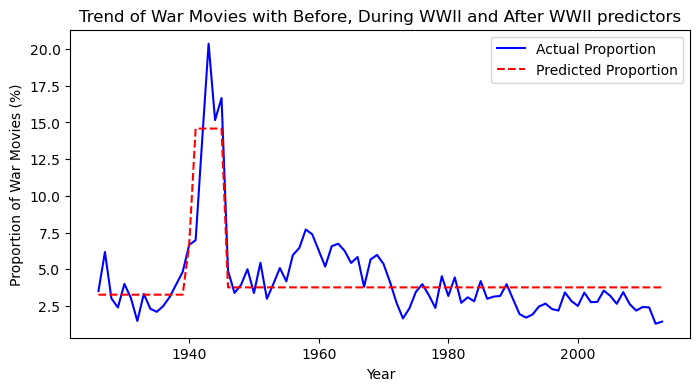

In [101]:
X = war_movies[['Before_WWII', 'During_WWII', 'After_WWII']]
y = war_movies['Proportion'].values

model, predicted_proportions2, summary = fit_and_evaluate_model(X, y)

r2 = r2_score(y, predicted_proportions2)
print(f"R-squared: {r2:.4f}")

plot_actual_vs_predicted(
    years=war_movies['Year'],
    actual=y,
    predicted=predicted_proportions,
    model=model,
    title='Trend of War Movies with Before, During WWII and After WWII predictors'
)

*3rd Case: The predictors choose are YEAR  and DURING*


R-squared: 0.6919


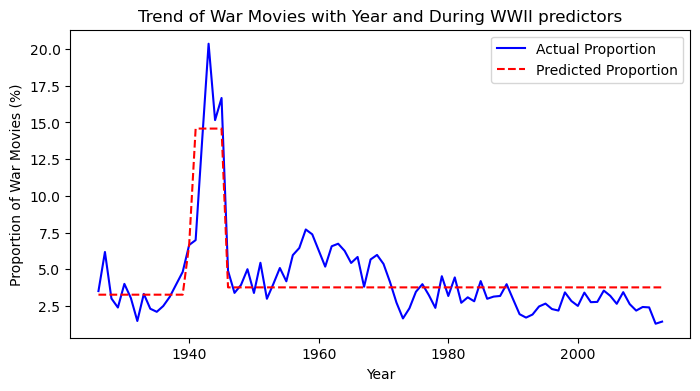

In [102]:
X = war_movies[['Year', 'During_WWII']]
y = war_movies['Proportion'].values

model, predicted_proportions3, summary = fit_and_evaluate_model(X, y)

r2 = r2_score(y, predicted_proportions3)
print(f"R-squared: {r2:.4f}")

plot_actual_vs_predicted(
    years=war_movies['Year'],
    actual=y,
    predicted=predicted_proportions,
    model=model,
    title='Trend of War Movies with Year and During WWII predictors'
)

**CONCLUSION:**

Even if all the model are very good performing, the model with the year and the during WWII predictor seems to be the best one with a r squared of **0.73**.

Let's look at the model in more detail

In [105]:
print(summary1)  

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     80.40
Date:                Tue, 17 Dec 2024   Prob (F-statistic):           1.30e-24
Time:                        15:28:49   Log-Likelihood:                -164.75
No. Observations:                  88   AIC:                             337.5
Df Residuals:                      84   BIC:                             347.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         100.8693     19.131      5.273      

R-squared: 0.742 – The model explains approximately 74.2% of the variation in the proportion of war movies.
 
- Year: -0.0504 (p < 0.001) – A realletively low negative trend over time.
- During_WWII: 11.5975 (p < 0.001) – A sharp and significant increase in the proportion of war movies during WWII.
- After_WWII: 2.6147 (p < 0.001) – A smaller but still significant increase after WWII compared to the long-term trend.

The equation of the model is:
$$
Proportion of War Movies=100.8693−0.0504×Year+11.5975×During_WWII+2.6147×After_WWII
$$

The fitted model shows a distinct jump in the predicted war movie proportions during WWII and a recalibrated level afterward, indicating that the war era fundamentally changed the landscape of war film production. Although the model cannot perfectly recreate the actual dramatic spike, the presence of significant dummy variable effects strongly suggests that WWII had a measurable, lasting influence on the proportion of war movies produced.

These results highlight the initial distinction we made: major historical events like wars cause sharp, short-term increases, while broader social movements may lead to more sustained trends over time.

### --> LGBT Movies and Key milestone in LGBT history

Following the analysis of war movies, which highlighted how major historical events like World War II create sharp, short-term spikes in film production, we now turn our attention to LGBT movies.
This case offers a different perspective by focusing on how broader social movements and cultural shifts influence cinematic trends.

Unlike wars, which are typically time-bound events with a clear beginning and end, the emergence of LGBT representation in cinema is more closely tied to long-term social progress. We thus hypothesis that key milestones, such as the first pride marches or significant legal advancements will not produce sudden spikes but instead contribute to a gradual, sustained increase in the production of LGBT-themed movies over time.

In [109]:
lgbt_movies = preprocessed_movies[preprocessed_movies['Genres'].str.contains(r'lgbt', case=False, na=False)]
lgbt_movies = lgbt_movies[lgbt_movies['Year'] < 2011]
lgbt_movies_per_year = lgbt_movies.groupby('Year').size()
lgbt_movies_proportion = (lgbt_movies_per_year / total_movies_per_year)*100
lgbt_events = preprocessed_history[preprocessed_history['Affected Population'].str.contains(r'lgbt', case=False, na=False)]

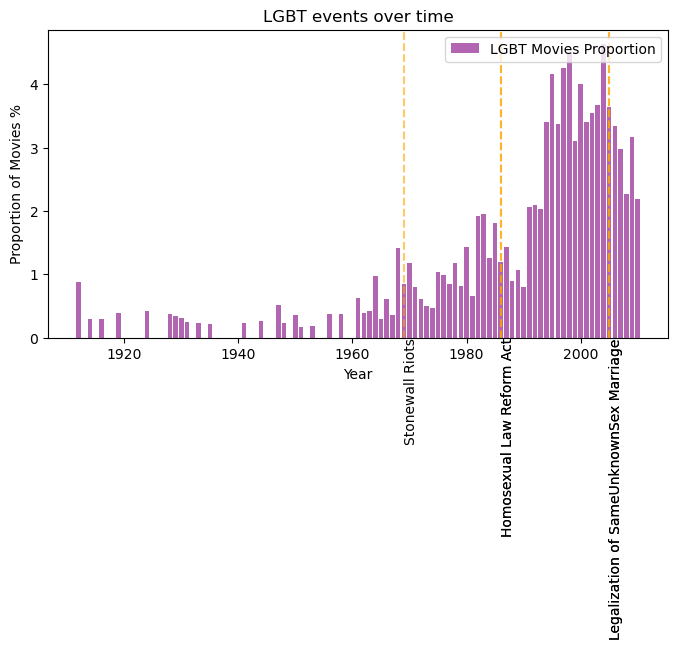

In [110]:
plt.figure(figsize=(8, 4))

#for lgbt events, plot a vertical line for each event
for year in lgbt_events[lgbt_events['Year'] < 2010]['Year']:
    plt.axvline(x=year, color='orange', linestyle='--', alpha=0.6)
    event_name = lgbt_events[lgbt_events['Year'] == year]['Name of Incident']
    if not event_name.empty:
        plt.text(year, 0, event_name.values[0], rotation=90, verticalalignment='top')
plt.bar(lgbt_movies_proportion.index, lgbt_movies_proportion.values, label='LGBT Movies Proportion', color='purple', alpha=0.6)
plt.xlabel('Year')
plt.ylabel('Proportion of Movies %')
plt.title('LGBT events over time')
plt.legend(loc='upper right')
plt.show()

### USA Case study

We look at the movies released in the USA that are classified as LGBT-themed because it is the hugest number of lgbt movie. We create a small data set with major event for the LGBT community in the USA. And we will see if there is a signification increase with specific event or over time only.
We removed al the film after 2010 as there is a decrease in film in the dataset in general and it seems to influence poorly our model,


In [111]:
usa_lgbt_movies = lgbt_movies[lgbt_movies['Countries']=='United States of America']
usa_lgbt_movies = usa_lgbt_movies[usa_lgbt_movies['Year'] < 2011]

total_movies_per_year_usa = preprocessed_movies[preprocessed_movies['Countries']=='United States of America'].groupby('Year').size()

print(f"Number of LGBT movies in United States {len(usa_lgbt_movies)}")
usa_lgbt_movies_per_year = usa_lgbt_movies.groupby('Year').size()
usa_lgbt_movies_proportion = (usa_lgbt_movies_per_year / total_movies_per_year)*100

Number of LGBT movies in United States 476


In [112]:
data = {
    "Year": [1924, 1969, 1973, 2004],
    "Event": [
        "Society for Human Rights",
        "Stonewall Riots",
        "Homosexuality Removed from mental disorders",
        "Same-Sex Marriage legalizes in first U.S. state"
    ],
    "Description": ["first documented gay rights organization in the U.S. is founded in Chicago by Henry Gerber",
                    "A watershed moment that catalyzed the modern LGBTQ+ rights movement, leading to the first Pride marches",
                    "The American Psychiatric Association removes homosexuality from its list of mental disorders, marking a major step toward acceptance",
                    "The first U.S. state to legalize same-sex marriage, setting the stage for national recognition"
    ]               
}

usa_lgbt_events= pd.DataFrame(data)

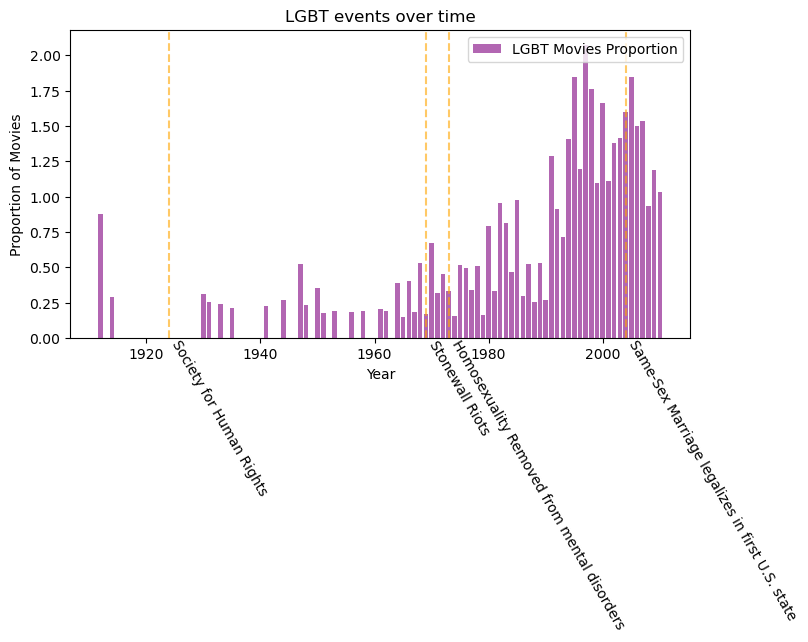

In [114]:
plt.figure(figsize=(8, 4))
#for lgbt events, plot a vertical line for each event
for year in usa_lgbt_events['Year']:
    plt.axvline(x=year, color='orange', linestyle='--', alpha=0.6)
    plt.text(year, 0, usa_lgbt_events[usa_lgbt_events['Year'] == year]['Event'].values[0], rotation=-60, verticalalignment='top')  
plt.bar(usa_lgbt_movies_proportion .index, usa_lgbt_movies_proportion .values, label='LGBT Movies Proportion', color='purple', alpha=0.6)
plt.xlabel('Year')
plt.ylabel('Proportion of Movies')
plt.title('LGBT events over time')
plt.legend(loc='upper right')
plt.show()


### **Hypothesis testing** : The prevalence of LGBT-themed movies follows a gradual temporal trend rather than experiencing significant shifts in response to key milestone events.

This suggests that changes in the number or proportion of LGBT-themed movies are more strongly correlated with the passage of time (a continuous trend) rather than being directly triggered by major historical or social events.

### -> **Model fitting**: To test this we will use a linear regression model on different predictors as for the war movies. We will see which model are the best to explain the data. 

*1st case: year as the only predictor*

In [ ]:
# Convert series to a DataFrame
war_movies = war_movies_proportion.to_frame(name='Proportion').reset_index()
war_movies = war_movies[war_movies['Year'] > 1925]

#Create all the dummies variable 
war_movies['Before_WWII'] = (war_movies['Year'] < 1940).astype(int)
# Choose 1941 for the start of WWI because it better fit to the peak of the war movies. An 1 year for movie production doesn't seem too much to consider.
war_movies['During_WWII'] = ((war_movies['Year'] >= 1941) & (war_movies['Year'] <= 1945)).astype(int)
war_movies['After_WWII'] = (war_movies['Year'] >= 1946).astype(int)

# Prepare the data
X = war_movies[['Year', 'During_WWII', 'After_WWII']]
y = war_movies['Proportion'].values

model, predicted_proportions1, summary1 = fit_and_evaluate_model(X, y)

r2 = r2_score(y, predicted_proportions1)
print(f"R-squared: {r2:.4f}")

plot_actual_vs_predicted(
    years=war_movies['Year'],
    actual=y,
    predicted=predicted_proportions1,
    model=model,
    title='Trend of War Movies with year, During WWII and After WWII predictors'

                                 OLS Regression Results                                
Dep. Variable:                 Counts   R-squared (uncentered):                   0.857
Model:                            OLS   Adj. R-squared (uncentered):              0.852
Method:                 Least Squares   F-statistic:                              185.8
Date:              mar., 17 déc. 2024   Prob (F-statistic):                    6.57e-27
Time:                        18:14:19   Log-Likelihood:                         -19.994
No. Observations:                  64   AIC:                                      43.99
Df Residuals:                      62   BIC:                                      48.31
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

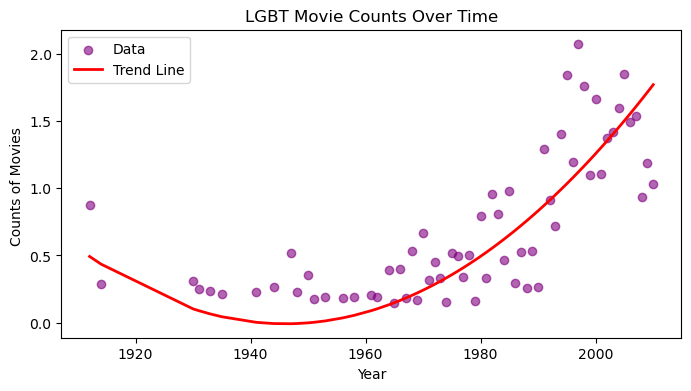

In [144]:
df = usa_lgbt_movies_proportion.reset_index()
df.columns = ['Year', 'Counts']
df['Year_centered'] = df['Year'] - df['Year'].mean()
df['Year_squared'] = df['Year_centered']**2  # Add quadratic term
df.dropna(inplace=True)

#think make more sens to not add an intercept in this case
#X = sm.add_constant(df[['Year_centered', 'Year_squared']])
X= df[['Year_centered', 'Year_squared']]
y = df['Counts']

# Fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

# Get predictions for plotting the trend line
pred = model.predict(X)

# Plot original data
plt.figure(figsize=(8,4))
plt.scatter(df['Year'], df['Counts'], label='Data', alpha=0.6, color='purple')

# Plot the trend line
plt.plot(df['Year'], pred, color='red', linewidth=2, label='Trend Line')

plt.xlabel('Year')
plt.ylabel('Counts of Movies ')
plt.title('LGBT Movie Counts Over Time')
plt.legend()
plt.show()

We used Ordinary Least Squares (OLS) regression with a quadratic term.

R value: = 0.86 --> the quadratic model explains 86% of the variance in LGBT movie counts

Coefficients:
- Year_centered: A coefficient of 0.3878 (p < 0.001) indicates a positive linear trend in LGBT movie counts over time.
- Year_squared: The positive coefficient of 0.0072 (p < 0.001) suggests a non-linear trend, with acceleration at certain points.

Both Year_centered and Year_squared terms are highly significant, showing the importance of both linear and quadratic effects.

The high F-statistic (102.0) and p-value (3.50e-20) confirm the model's strong fit overall.

*2nd case: Keymilestones as dummy predictor*

In [145]:
#We will define the following periods of 5 years as the one folowwing key milestone: 
usa_lgbt_movies = usa_lgbt_movies_proportion.to_frame(name='Proportion').reset_index()

#Society for human rights (1924)
usa_lgbt_movies['shr_period'] = (usa_lgbt_movies['Year']>=1925) & (usa_lgbt_movies['Year']<=1930).astype(int)

#StoneWall riots (1969) & Homosexuality removed from mental disorders (1973)
usa_lgbt_movies['stone_wall_period'] = (usa_lgbt_movies['Year']>=1974) & (usa_lgbt_movies['Year']<=1979).astype(int)    

#Same sex mariage legalizes in first U.S. state (2004)
usa_lgbt_movies['marriage_legalized_period'] = (usa_lgbt_movies['Year']>=2005) & (usa_lgbt_movies['Year']<=2010).astype(int)


In [146]:
X = usa_lgbt_movies[['shr_period', 'stone_wall_period', 'marriage_legalized_period']].astype(float)
y = usa_lgbt_movies['Proportion'].values

# Drop rows wherexand  y is NaN
X = X[~np.isnan(y)]
y = y[~np.isnan(y)]

model, predicted_proportions1, summary = fit_and_evaluate_model(X, y)

r2 = r2_score(y, predicted_proportions1)
print(f"R-squared: {r2:.4f}")


R-squared: 0.1846


As we could have guess from the barplot. The model with only the predict doesn't explain a lot of the variability of the data. There is no clear change after each event. Let's try to select only the ke ymilestone that seem to have influence on the plot (let's try the period after stone wall). And let's keep the year.

In [147]:
usa_lgbt_movies['Year_centered'] = usa_lgbt_movies['Year'] - usa_lgbt_movies['Year'].mean()
usa_lgbt_movies['Year_squared'] = usa_lgbt_movies['Year_centered']**2

X = usa_lgbt_movies[['Year_centered','Year_squared','stone_wall_period',]].astype(float)
y = usa_lgbt_movies['Proportion'].values

# Drop rows where x and y are NaN
X = X[~np.isnan(y)]
y = y[~np.isnan(y)]


model, predicted_proportions2, summary = fit_and_evaluate_model(X, y)

r2 = r2_score(y, predicted_proportions2)
print(f"R-squared: {r2:.4f}")


R-squared: 0.6774


THis model has worst performance to explain the variance of our data compare to the first one.

# brouillon de la partie d avant

The baseline scenario (no events) shows the predicted probability of LGBT-themed movies over time, purely based on the time trend without external influences.
For each event (e.g., post-decriminalization of homosexuality, post-Stonewall riots, post-legalization of same-sex marriage), the graph shows the predicted probabilities with that event "turned on" at its corresponding year.

In [64]:
preprocessed_movies['is_lgbt'] = preprocessed_movies['Genres'].str.contains(r'lgbt', case=False, na=False).astype(int)

def safe_colname(name):
    return 'post_' + ''.join(e if e.isalnum() else '_' for e in name.lower())

# Create dummy variables for each LGBT-related event
for _, row in lgbt_events.iterrows():
    event_year = row['Year']
    event_name = row['Name of Incident']
    col_name = safe_colname(event_name)
    preprocessed_movies[col_name] = (preprocessed_movies['Year'] >= event_year).astype(int)

# Center the Year variable
preprocessed_movies['Year_centered'] = preprocessed_movies['Year'] - preprocessed_movies['Year'].mean()

# Define predictors: Year_centered + all event dummies
predictors = ['Year_centered']
event_dummy_cols = [col for col in preprocessed_movies.columns if col.startswith('post_')]
predictors += event_dummy_cols

# Create the X and y matrices
X = preprocessed_movies[predictors]
y = preprocessed_movies['is_lgbt']
# Drop the columna identified as perfectly correlated
if 'post_homosexual_law_reform_act' in X.columns:
    X = X.drop(columns=['post_homosexual_law_reform_act'])

if 'post_approval_of_sameunknownsex_marriage' in X.columns:
    X = X.drop(columns=['post_approval_of_sameunknownsex_marriage'])

#drop unstable column 
if 'post_sameunknownsex_marriage_legalized' in X.columns:
    X = X.drop(columns=['post_sameunknownsex_marriage_legalized'])

# Update event_dummy_cols after dropping the column
event_dummy_cols = [col for col in X.columns if col.startswith('post_')]

# Fit logistic regression
model_logit = sm.Logit(y, sm.add_constant(X)).fit()

print(model_logit.summary())

Optimization terminated successfully.
         Current function value: 0.078854
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                is_lgbt   No. Observations:                68131
Model:                          Logit   Df Residuals:                    68126
Method:                           MLE   Df Model:                            4
Date:                Tue, 17 Dec 2024   Pseudo R-squ.:                 0.07267
Time:                        14:58:35   Log-Likelihood:                -5372.4
converged:                       True   LL-Null:                       -5793.5
Covariance Type:            nonrobust   LLR p-value:                5.897e-181
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                  

In [46]:
# Generate a range of years to predict over
years_to_plot = np.arange(preprocessed_movies['Year'].min(), preprocessed_movies['Year'].max() + 1)
plot_df = pd.DataFrame({'Year': years_to_plot})
plot_df['Year_centered'] = plot_df['Year'] - preprocessed_movies['Year'].mean()

# Identify event columns (final set you used in the model)
# Make sure these match the model you have fitted exactly.
event_dummy_cols = [
    'post_decriminalization_of_homosexuality',
    'post_stonewall_riots',
    'post_legalization_of_sameunknownsex_marriage'
]

# Function to set event dummies for a given scenario
def set_event_scenario(df, events, scenario='baseline'):
    df_scenario = df.copy()
    # Start with all events off (0)
    for ev_col in event_dummy_cols:
        df_scenario[ev_col] = 0
    
    if scenario == 'baseline':
        return df_scenario
    
    # If scenario is one event at a time
    for event in events:
        if scenario == event['col_name']:
            # This event turns on at and after event['year']
            df_scenario.loc[df_scenario['Year'] >= event['year'], event['col_name']] = 1

    return df_scenario

# Prepare scenarios
# 1) Baseline (no events)
scenarios = [('Baseline', 'baseline')]

# Define events_info
events_info = []
for col_name in event_dummy_cols:
    event_year = preprocessed_movies[preprocessed_movies[col_name] == 1]['Year'].min()
    events_info.append({'col_name': col_name, 'year': event_year})

# 2) Each event on its own
for ev in events_info:
    scenarios.append((ev['col_name'], ev['col_name']))

plt.figure(figsize=(8,4))

for label, scenario in scenarios:
    df_scenario = set_event_scenario(plot_df, events_info, scenario=scenario)
    # Construct X_scenario using the same predictors model_logit was trained on
    X_scenario = df_scenario[['Year_centered'] + event_dummy_cols]
    print(event_dummy_cols)
    X_scenario = sm.add_constant(X_scenario)  # Add the const column
    
    # Predict probabilities
    df_scenario['predicted_prob'] = model_logit.predict(X_scenario)
    
    # Plot the scenario line
    plt.plot(df_scenario['Year'], df_scenario['predicted_prob'], label=label)

plt.xlabel('Year')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probability of LGBT-themed Movies Over Time with Different Event Scenarios')
plt.legend()
plt.show()

KeyError: 'post_decriminalization_of_homosexuality'

## VOIR POUR CETTE PARTIE 

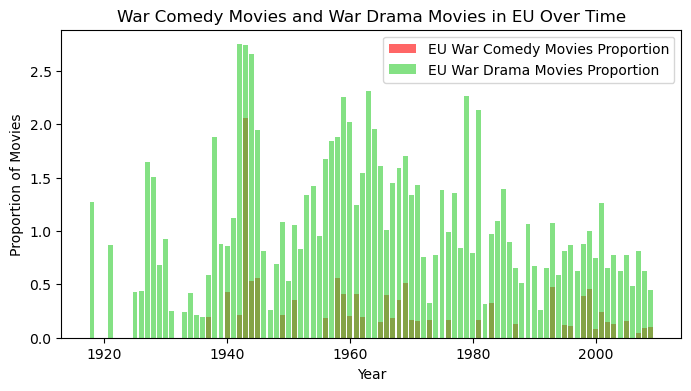

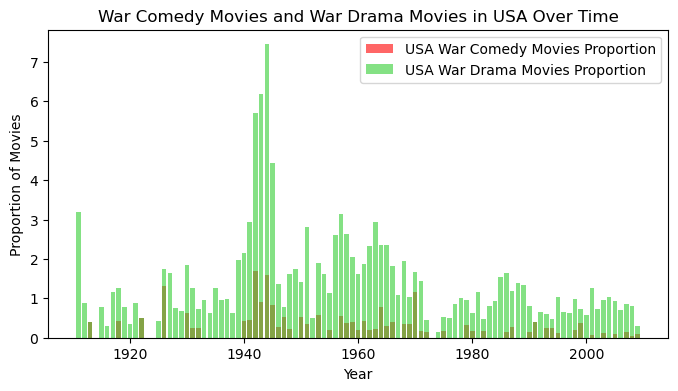

In [65]:
regions = {
    'EU': ['France', 'United Kingdom', 'Poland', 'Netherlands', 'Belgium', 
           'Sweden', 'Norway', 'Austria', 'Soviet Union', 'Greece', 'Yugoslavia'],
    'USA': ['United States of America']
}

for region, countries in regions.items():
    analyze_war_movies(region, countries, War_movies_comedy, War_movies_drama, total_movies_per_year)
    


The graph clearly shows that the theme of war is much more frequently portrayed from a dramatic rather than a comedic perspective. However, even if WWII had a global impact, experiences vary greatly from one region of the world to another. When comparing this proportion between european countries where war was being fought and for example the United States of America (chosen because it is the largest producer of movies worldwide), we see that the war comedic perspective is much more present, showing a first hint of comedies being an escape. 

### ➔ Propaganda movies during WWII

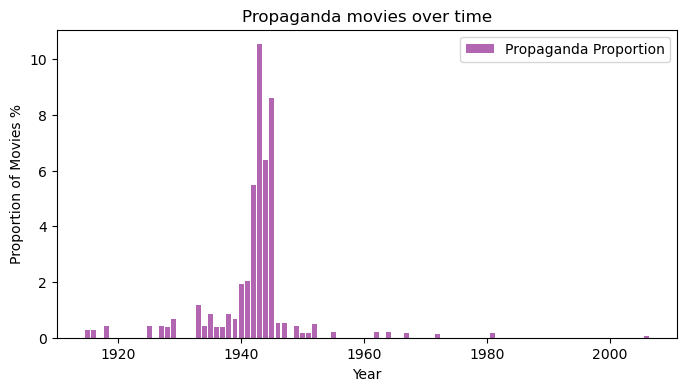

In [66]:
propaganda = preprocessed_movies[preprocessed_movies['Genres'].str.contains(r'propaganda', case=False, na=False)]
propaganda_per_year = propaganda.groupby('Year').size()
propaganda_proportion = (propaganda_per_year / total_movies_per_year)*100
plt.figure(figsize=(8, 4))
plt.bar(propaganda_proportion.index, propaganda_proportion.values, label='Propaganda Proportion', color='purple', alpha=0.6)
plt.xlabel('Year')
plt.ylabel('Proportion of Movies %')
plt.title('Propaganda movies over time')
plt.legend(loc='upper right')
plt.show()

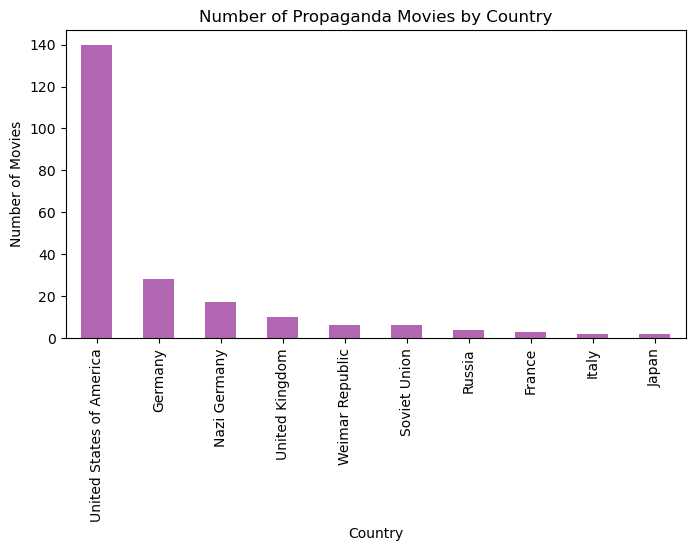

In [67]:
#group propaganda movies by country
propaganda_countries = propaganda['Countries'].str.split(', ').explode().value_counts()
propaganda_countries = propaganda_countries[propaganda_countries > 1]
propaganda_countries = propaganda_countries.sort_values(ascending=False)

plt.figure(figsize=(8, 4))
propaganda_countries.plot(kind='bar', color='purple', alpha=0.6)
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.title('Number of Propaganda Movies by Country')
plt.show()

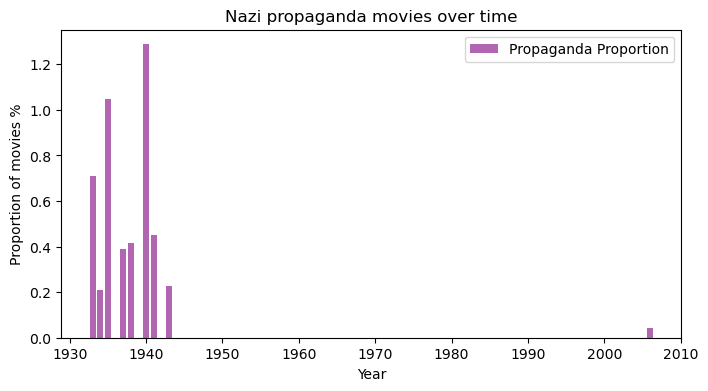

In [68]:
nazi_propaganda = preprocessed_movies[preprocessed_movies['Countries'].str.contains(r'nazi', case=False, na=False)]
nazi_propaganda_per_year = nazi_propaganda.groupby('Year').size()
nazi_propaganda_proportion = (nazi_propaganda_per_year / total_movies_per_year)*100

plt.figure(figsize=(8, 4))
plt.bar(nazi_propaganda_proportion.index, nazi_propaganda_proportion.values, label='Propaganda Proportion', color='purple', alpha=0.6)
plt.xlabel('Year')
plt.ylabel('Proportion of movies %')
plt.title('Nazi propaganda movies over time')
plt.legend(loc='upper right')
plt.show()

We can see that the nazi propaganda movies started in the 30s and lasted until the end of WWII. A single one of them was released in 2006. Is it due to neonazis movements ? Let's investigate what it is.

In [69]:
nazi_propaganda = nazi_propaganda.sort_values(by='Year')
nazi_propaganda.tail(1)

,Movie name,Movie box office revenue,Movie runtime,Languages,Countries,Genres,Year,is_lgbt,post_homosexual_law_reform_act,post_decriminalization_of_homosexuality,post_stonewall_riots,post_legalization_of_sameunknownsex_marriage,post_sameunknownsex_marriage_legalized,post_approval_of_sameunknownsex_marriage,Year_centered
34259,Kampf um Norwegen - Feldzug 1940,NaN,80.0,German,"Nazi Germany, Germany","Short Film, War film, Propaganda film, Documen...",2006,0,1,1,1,1,0,1,28.647238


Battle for Norway – Campaign 1940 is a German propaganda film produced by the UFA in 1940 by the High Command of the Wehrmacht.
The film was considered lost for a long time. It was not found by the Norwegian film historian Jostein Saakvitne randomly in 2000 in the offer of a militaria online auction house. These were five film rolls with a total weight of 20 kilograms. The film changed the owner anonymously for less than 1000 euros. 
On the 20th The film first premiered after the war by the film institute Oslo in September 2006. The film was not performed in Germany. 

We aim to expand our analysis beyond just war movies and WWII. To do this, we will focus on selecting a few genres and events for our study. We will first explore the Genre column and then examine a new dataset for the events.

In [70]:
total_movies_per_year

Year
1888       1
1889       1
1890       2
1891       1
1892       3
        ... 
2005    1947
2006    2271
2007    2212
2008    2251
2009    2019
Length: 122, dtype: int64

In [71]:
#Cut at year 2010 because of the low number of movies after that year
total_movies_per_year = preprocessed_movies[preprocessed_movies['Year'] <= 2009].groupby('Year').size()

These analysis done let's focus on all the movies genre that we got and that have maybe less evident impact regarding historical event.

## MOVIES GENRES

In this section, we will examine how movies are classified into genres. Carefully analyzing, selecting and refining these genre classifications is essential for obtaining meaningful insights. 
We will discuss our approach to selecting and adjusting genres for our following study. 

In [72]:
#Number of genres in the dataset but we can see that there are a lot of categories that could be combined
genres = preprocessed_movies['Genres'].str.split(', ').explode().unique()

print(f"There are {len(genres)} genres in the dataset")

There are 362 genres in the dataset


In [73]:
#print(f"Genres in the dataset are: {genres}")

Movies are classified into a wide variety of genres that reflect themes, styles, cultural contexts, narrative forms, or settings. However, not all of these dimensions are directly relevant to our analysis, so it is necessary to select genres that enable meaningful grouping of films.

There are several approaches we could take to group movies:
1. Select the most popular genres.
2. Identify correlations between genres to consolidate them into broader categories.
3. Manually select the genres most relevant to our analysis.

We will explore the first two options, and if they prove insufficient, we will resort to the third approach, which remains feasible given that manually handling 300 genres is manageable.

#### 1) Most Popular Genre

Number of genres assigned to more than 50 movies: 196.


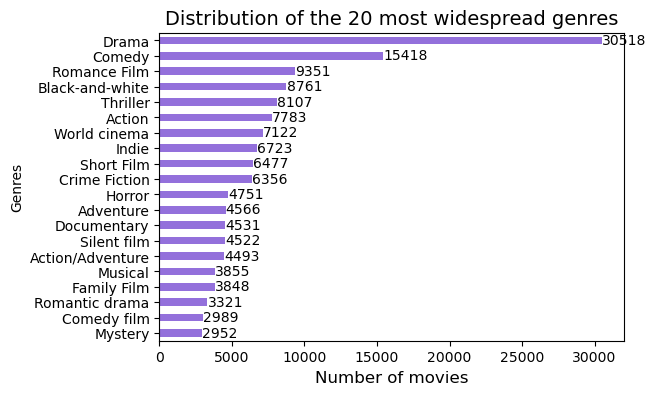

In [74]:
genres_counts = preprocessed_movies['Genres'].str.split(', ').explode().value_counts()

#Only keep genres that have been assigned to more than 50 movies
threshold = 50
relevant_genres = genres_counts[genres_counts > threshold]
print(f"Number of genres assigned to more than {threshold} movies: {len(relevant_genres)}.")

#20 most widespread genres
top_20_genres = relevant_genres.head(20)

plt.figure(figsize=(6, 4))
top_20_genres.plot(kind='barh', color='#9370DB')
plt.xlabel('Number of movies', fontsize=12)
plt.title('Distribution of the 20 most widespread genres', fontsize=14)
plt.gca().invert_yaxis() 

for index, value in enumerate(top_20_genres):
    plt.text(value + 10, index, str(value), va='center')
plt.show()

Many genres in the dataset may not be meaningful for our analysis because they contain very few movies, making it difficult to observe any trends over time for these genres. To focus on relevant genres, we can set an arbitrary threshold for the minimum number of movies assigned to each genre.

We also reviewed the top 20 genres to examine their distribution and identify which ones might be significant.

One immediate observation is that the genres are not inherently comparable, as they often describe entirely different aspects of a film. For example, comparing trends between "Black-and-White Film" and "Comedy" is problematic. The former describes a technical characteristic, while the latter defines the tone or mood of a film, and these categories are not mutually exclusive. A film can be both a black-and-white film and a comedy simultaneously. 

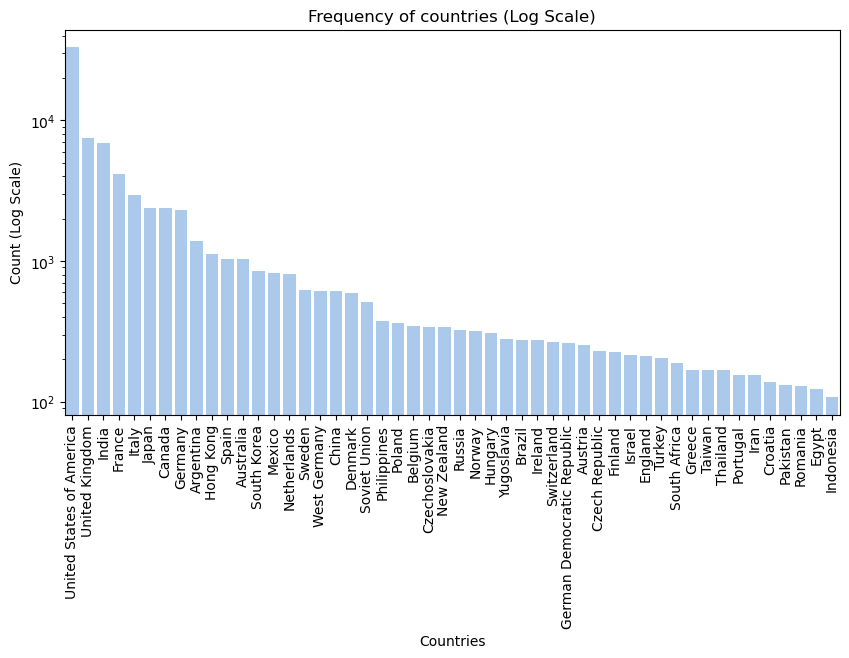

The number of American movies is 33104 which corresponds to 48.59% of the total number of movies.


In [75]:
top_n = 50

countries_counts = preprocessed_movies['Countries'].str.split(', ').explode().value_counts()
top_countries = countries_counts.head(top_n)
top_countries_df = top_countries.reset_index()
top_countries_df.columns = ['Countries', 'Count']

#Using a logarithmic scale
plt.figure(figsize=(10,5))
sns.barplot(x='Countries', y='Count', data=top_countries_df)
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Frequency of countries (Log Scale)')
plt.ylabel('Count (Log Scale)')
plt.show()

# show the percentage of english language movies compared to the total number of movies
american_movies = preprocessed_movies['Countries'].str.contains('United States of America').sum()
print(f"The number of American movies is {american_movies} which corresponds to {american_movies/len(preprocessed_movies)*100:.2f}% of the total number of movies.")

As the number of American movies corresponds to half of the worldwide movie industry, we will focus on the the impact of the historical events on genre trends in this country. Let's see what are the main events.

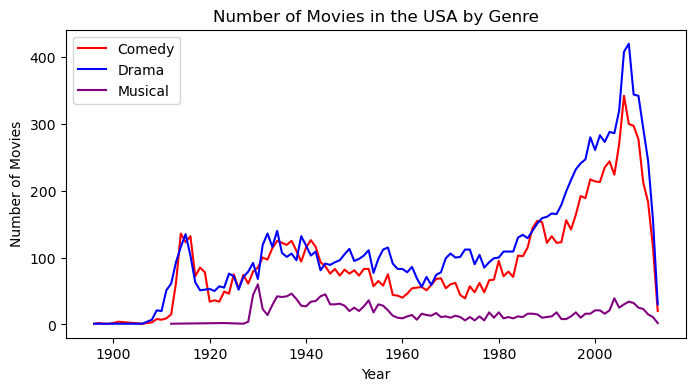

In [76]:
# Define genre categories
genres = {
    "Comedy": ["Comedy", "Comedy-drama", "Adventure Comedy", "Black comedy", "Romantic comedy", 
               "Comedy horror", "Musical comedy", "Screwball comedy", "Comedy Western", "Comedy Thriller"],
    "Drama": ["Drama", "Comedy-drama", "Romantic drama", "Political drama", "Historical drama", 
              "Family Drama", "Melodrama"],
    "Musical": ["Musical", "Musical comedy", "Musical Drama", "Animated Musical"]
}

# Create patterns for each genre
genre_patterns = {key: '|'.join(value) for key, value in genres.items()}

# Function to filter movies by genre and country
def filter_genre_country(df, genre_pattern, country="United States of America"):
    return df[df['Countries'].str.contains(country) & df['Genres'].str.contains(genre_pattern, case=False, na=False)]

# Filter movies for each genre
filtered_data = {genre: filter_genre_country(preprocessed_movies, pattern) for genre, pattern in genre_patterns.items()}

# Group by year and count movies
movies_per_year = {genre: data.groupby('Year').size() for genre, data in filtered_data.items()}

# Plot the data
plt.figure(figsize=(8, 4))
for genre, data in movies_per_year.items():
    plt.plot(data.index, data.values, label=genre, color={'Comedy': 'red', 'Drama': 'blue', 'Musical': 'purple'}[genre])

plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies in the USA by Genre')
plt.legend()
plt.show()



We can see the rise of musical genre in the 30s.

In [77]:
# events in the USA starting from 1925 to 1930
USA_events = preprocessed_history[preprocessed_history['Country'] == 'United States of America']
USA_events = USA_events[USA_events['Year'].between(1925, 1930)].sort_values(by='Year')
USA_events.head()

,Name of Incident,Year,Country,Type of Event,Impact,Affected Population,Important Person/Group Responsible,Outcome
621,Stock Market Crash of 1929,1929,United States of America,Economic,"Led to the Great Depression, impacting global ...",Global population,Unknown,Negative


Hypothesis: The Great Depression stimulated the rise of musical films due to the need for escapism and entertainment.

The Great Depression, starting with the 1929 stock market crash, led to widespread economic hardship, with unemployment rates exceeding 25% and significant declines in industrial output. In this period of despair, people sought escapism and affordable entertainment to cope with the harsh realities of daily life. However the rise and maintaining of the musical genre is not only due to the need for escapism during the Great Depression, but also because the advent of synchronized sound (The Jazz Singer in 1927) revolutionized the industry, allowing dialogue, music, and dance to be seamlessly integrated into films. Before the late 1920s, films were silent, with music provided by live orchestras. 

### 2) Correlation Between Genres

Based on the genre names alone, we can anticipate that certain genres might be correlated, appearing together frequently in movies. To explore these relationships, we’ll create a heatmap to visualize genre associations and identify any genres that are commonly paired in films.

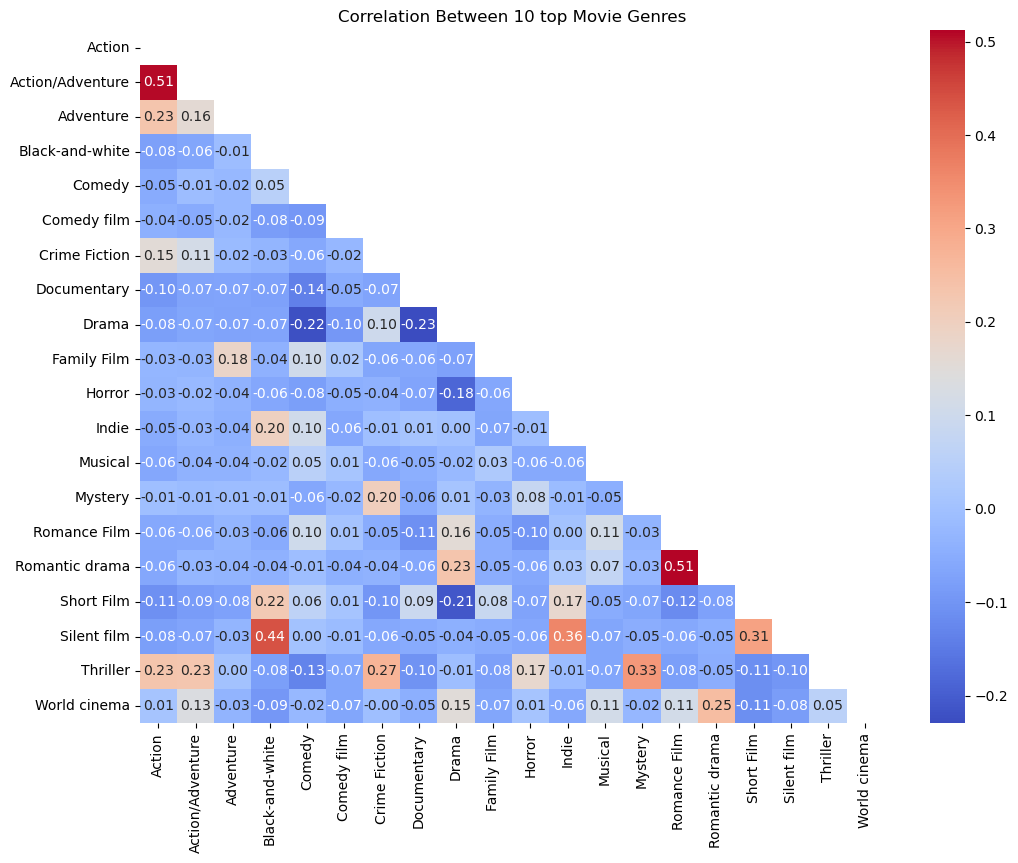

In [78]:
genre_movies = preprocessed_movies['Genres'].str.split(', ').explode()
genre_counts = genre_movies.value_counts().reset_index()
genre_counts.columns = ['Genres', 'Count']

genre_counts_top_20 = genre_counts.iloc[:20]
most_20commongenres,coverage20 = most_common_genres(preprocessed_movies, genre_counts_top_20, 20)
most_20commongenres = most_20commongenres.dropna(subset=['Genres'])

#Tranform the multi label genre of each movie into a binary matrix where each column represent a genre and each row a movie. If the movie is classified into the genre the value is 1 otherwise it is 0
mlb = MultiLabelBinarizer()

genre_binary_matrix = pd.DataFrame(mlb.fit_transform(most_20commongenres['Genres'].str.split(', ')), columns=mlb.classes_, index=most_20commongenres.index)
genre_correlation = genre_binary_matrix.corr()

plt.figure(figsize=(12, 9))
mask = np.triu(np.ones_like(genre_correlation, dtype=bool))
sns.heatmap(genre_correlation, mask=mask, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Between 10 top Movie Genres')
plt.show()

This heatmap illustrates how frequently two genres are used together to describe the same movie.

For example, the combination of "Crime Fiction" and "Thriller" shows a moderate positive correlation (0.26), suggesting that these genres often co-occur, meaning that movies labeled as "Crime Fiction" frequently include elements of "Thriller" as well. However, this co-occurrence is only moderately consistent across the dataset.

On the other hand, "Drama" and "Documentary" have a strong negative correlation (-0.28), indicating that these genres are rarely used together. This suggests that movies classified as "Drama" are typically not labeled as "Documentary" and vice versa.

We also observe some logical correlations between genres. For example, "Romance Film" has a strong correlation (0.50) with "Romantic Drama," and "Thriller" is correlated with "Crime Thriller" (0.43). This reflects how closely related these genre classifications are.

Ideally, a "Crime Thriller" would always be classified as a "Thriller," so the correlation should be 1. However, since movies are sometimes labeled with just one of these terms, we see a lower correlation. This suggests potential inconsistencies in labeling, where similar genres are named differently or only partially.

One solution might be to group genres with similar names. However, it’s not always straightforward. For example, if we consider "Romantic Drama" and "Romantic Comedy," should both be grouped under "Romance"? Or should one go under "Drama" and the other under "Comedy"? Alternatively, should each be classified in both "Romance" and their respective sub-genres ("Drama" or "Comedy")? The choice of grouping depends on how we want to structure the genre hierarchy and whether we aim to capture both overarching themes and specific sub-genres.

# Case studies by Dianus

## 1) Watergate Scandal (1972) and Political Films

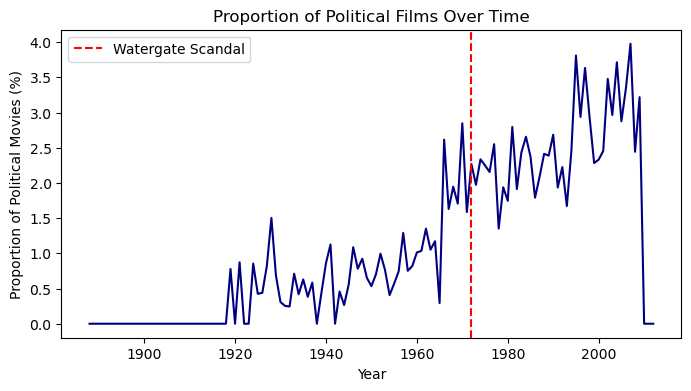

In [79]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, r'political', 'Political', 'Watergate Scandal', (1972, 1972), is_period=False)

It appears that the Watergate Scandal had no significant impact on the production of political movies globally. 
Let's focus on the analysis of American movies only.

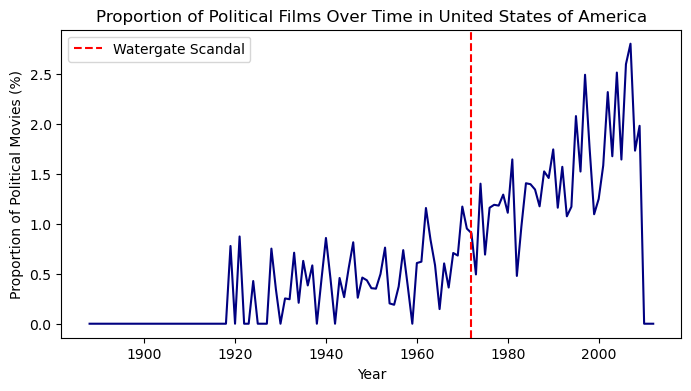

In [80]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, r'political', 'Political', 'Watergate Scandal', (1972, 1972), country='United States of America', is_period=False)

It appears that the Watergate Scandal did not have a significant influence on the proportion of political movies produced in the USA. 
The trend shows an increase of political movies before the Watergate scandal, suggesting that other factors may have played a more crucial role in shaping the genre's popularity.
** à verifier avec statistical analysis **

## 2) The Cuban Missile Crisis (1962) and Spy Movies

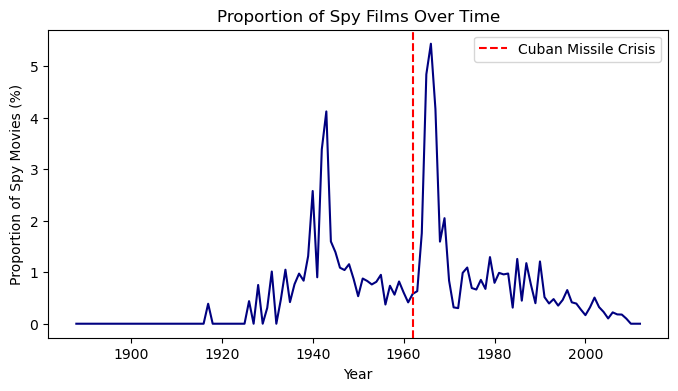

In [81]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, r'spy', 'Spy', 'Cuban Missile Crisis', (1962, 1962), is_period=False)

We notice a big peak following the Cuban Missile Crisis, a time when people were anxious about the threat of nuclear war. This fear likely made Cold War themes feel more relevant and sparked greater interest in the spy genre during that period.

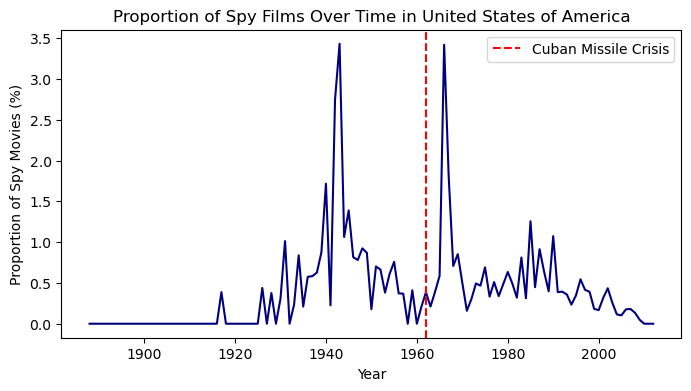

In [82]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, r'spy', 'Spy', 'Cuban Missile Crisis', (1962, 1962), country='United States of America', is_period=False)

## 3) The Atomic Bomb and Creature Movies

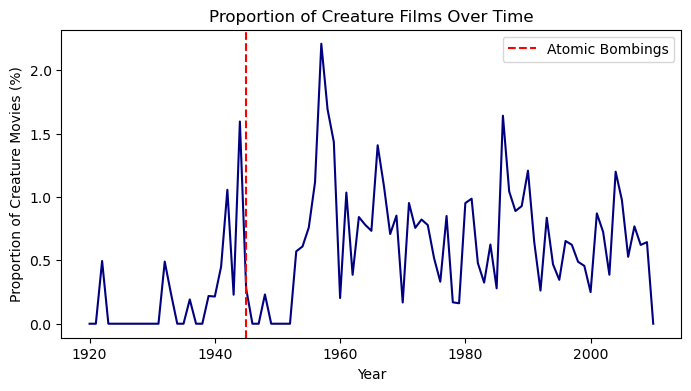

In [83]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, r'creature', 'Creature', 'Atomic Bombings', (1945, 1945), start=1920, is_period=False)

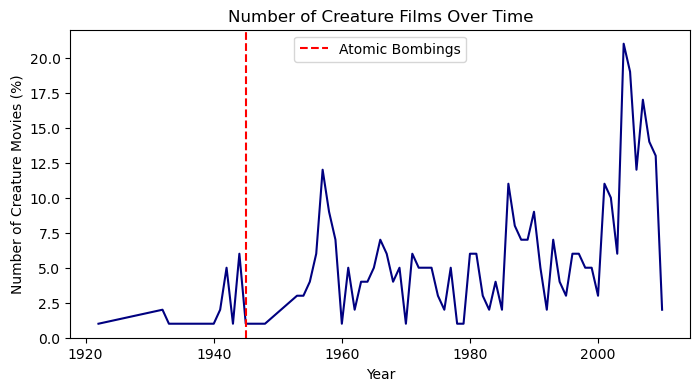

In [84]:
plot_genre_number_and_event(preprocessed_movies, r'creature', 'Creature', 'Atomic Bombings', (1945, 1945), is_period=False)

The peak in the number of creature movies between 1955 and 1960 may be linked to the atomic bombings of 1945, though the delay suggests that society needed time to process the trauma and implications of this unprecedented event. The early post-war years likely focused on recovery and reflection, but as the fear of nuclear radiation and its potential effects grew—especially with the onset of the Cold War—these anxieties began to manifest in popular culture.

Creature movies during this period often explored themes of mutation, destruction, and the unknown, reflecting public fears about the consequences of nuclear radiation. However, further analysis is needed to determine the extent to which nuclear concerns directly influenced these films or whether they were part of a broader trend in science fiction and horror responding to the uncertainties of the era.

## 4) Prohibition in the USA (1920-1933) and Crime Movies 

c:\Users\lucil\Desktop\EPFL\MA3\ada-2024-project-nostringsadached\src\utils\visualization.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  start (int, optional): The year to start the plot from. If None, starts from the earliest year.


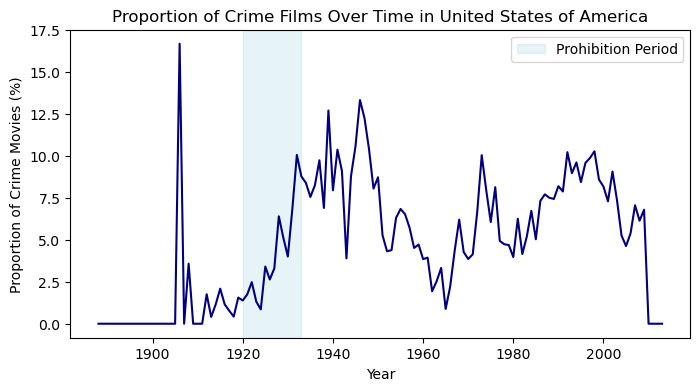

In [85]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, r'(gangster|crime)', genre_name='Crime', event_name='Prohibition Period', event_dates=(1920, 1933), country='United States of America', is_period=True)

We notice a steep increase in the proportion of crime movies in the United States during the Prohibition. After Prohibition ended, crime remained a  social issue, with lingering effects of organized crime that had taken root during the 1920s. This could explain why the popularity of crime movies remained high until 1945. Following this period, the genre experienced a decline, likely reflecting a shift in public interest.

## 5) Indian Civil Rights Act (1968) and Western Movies

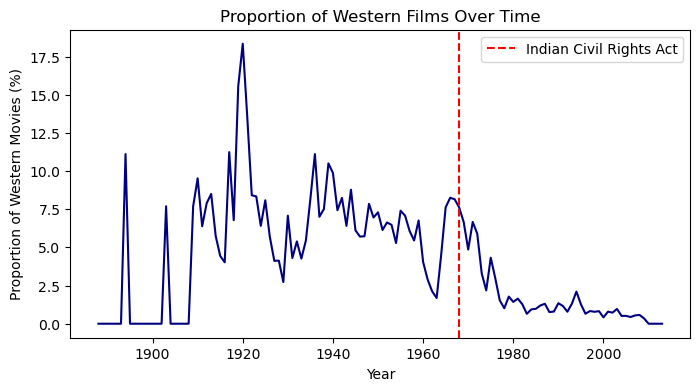

In [86]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'western', genre_name='Western', event_name='Indian Civil Rights Act', event_dates=(1968, 1968), is_period=False)

After the Indian Civil Rights Act of 1968, we notice a stronger decrease of the proportion of western movies, which becomes negligible in the 1980s. This likely reflects the changing societal attitudes and a growing awareness of the historical injustices faced by Native American communities. 

## 6) Major special effects advancements (late 1970s) and Science-Fiction Movies

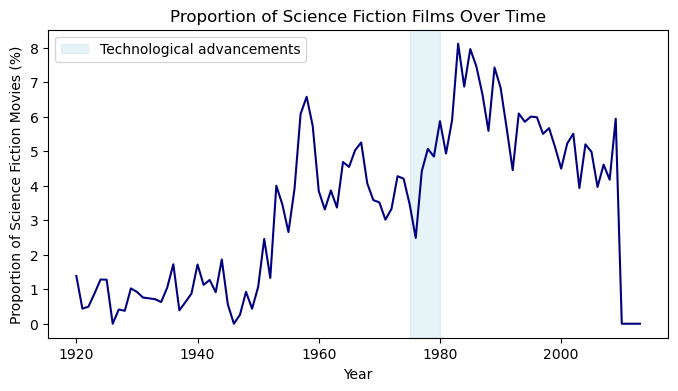

In [87]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'Science Fiction', genre_name='Science Fiction', event_name='Technological advancements', event_dates=(1975, 1980), start=1920, is_period=True)

There is a steep increase in the proportion of science-fiction movies starting in the mid-1970s, which coincides with the rise of the blockbuster era. This growth is likely driven by the integration of advanced visual effects techniques, such as Computer-Generated Imagery (CGI), introduced between 1973 and 1982, along with motion control cameras and animatronics, which became widely used in the late 1970s. Additionally, the surge in the 1980s may be linked to renewed public interest in space exploration, due to the launch of the Space Shuttle program in 1981 for example.

## 7) Technicolor technique (1916) and Black-and-white Movies

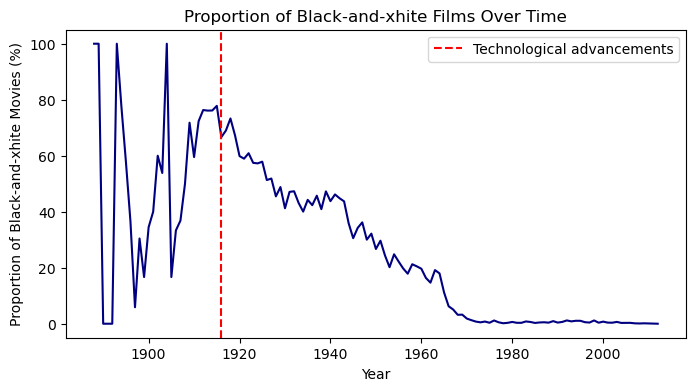

In [88]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'Black-and-white', genre_name='Black-and-xhite', event_name='Technological advancements', event_dates=(1916, 1916), is_period=False)

The decline of the prevalence of black-and-white movies can be easily explained by the invention of the first technicolor technique in 1916, which was later improved. Progressivly, color films became more affordable and accessible and overtakook black-and-white movies.


## 8) Sound Technologies (1927) and Silent Movies

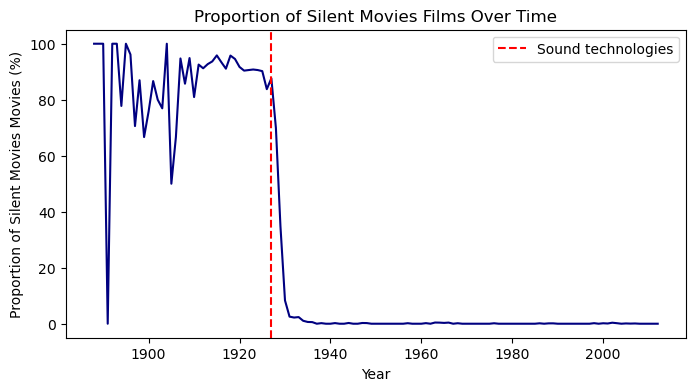

In [89]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'Silent', genre_name='Silent Movies', event_name='Sound technologies', event_dates=(1927, 1927), is_period=False)

The introduction of sound in movies became possible with the Vitaphone system invented in 1927. The release of The Jazz Singer, the first movie with dialogue and music, was a turning point. Silent films became rapidly obsolete.